# Evasion

> Attacks against classification models that construct special inputs (a.k.a adversarial examples) that appear natural to a human but are misclassified by the model.

In [1]:
#| default_exp evasion

In [2]:
#| hide
from nbdev.showdoc import *

In [3]:
#| export
from advertorch.attacks import LinfPGDAttack
from typing import Callable

import torch
from fastai.vision.all import *

from torch.nn import Module, Sequential
from torch.nn.parameter import Parameter


class LinfProjectionCallback(Callback):
    def __init__(self, epsilon, x, rand_init):
        super().__init__()
        self.epsilon = epsilon
        self.p = Parameter(torch.rand(x.shape) * self.epsilon if rand_init else torch.zeros(x.shape))
        self.clamp_pixel_values(x)

    def before_step(self):
        with torch.no_grad():
            self.p.grad.sign_()

    def after_batch(self):
        with torch.no_grad():
            self.p.clamp_(-self.epsilon, self.epsilon)  # keep perturbation small
            self.clamp_pixel_values(self.x)

    def clamp_pixel_values(self, x):
        with torch.no_grad():
            x = x.to(self.p.device)
            self.p.data = (x + self.p).clamp(0., 1.) - x


class PGD(object):
    def __init__(self,
                 model: Module,
                 loss: Callable,
                 targeted: bool,  # Whether the constructed inputs should be classified as the specified targets or not
                 min_delta: float = 1e-2,  # Minimum loss delta for `ReduceLROnPlateau` and `EarlyStoppingCallback`
                 min_lr: float = 1e-6,  # Minimum lr for `ReduceLROnPlateau`
                 lr: float = None,  # pass `None` to pick `lr` based on other params
                 # defaults taken from advertorch
                 epsilon: float = 0.3,
                 epoch_size: int = 10,  # Affects how often epoch-callbacks are called (e.g. `Recorder`` and `EarlyStoppingCallback`)
                 n_epochs: int = 4,
                 rand_init: bool = True):
        self.loss = loss if targeted else (lambda *args, **kwargs: -loss(*args, **kwargs))
        self.lr = lr or (epsilon / epoch_size)
        store_attr('model, min_delta, min_lr, epsilon, epoch_size, n_epochs, rand_init')

    def perturb_dl(self, dl: DataLoader):
        return torch.cat([self.perturb_batch(x, y) for x, y in dl])

    def perturb(self, dsets):
        x, y = dsets.load()
        x, y = x.detach().clone(), y.detach().clone()  # TODO: can I get rid of this?
        self.model.eval()
        self.model.requires_grad_(False)

        proj_callback = LinfProjectionCallback(self.epsilon, x, self.rand_init)
        pert_module = Lambda(proj_callback.p.add)
        pert_module.p = proj_callback.p  # to register as a parameter

        class TrainLoop(TrainEvalCallback):
            def before_train(self):
                super().before_train()
                self.model.eval()

            def before_validate(self):
                raise CancelValidException

        learner = Learner(DataLoaders([(x, y) for _ in range(self.epoch_size)], []),
                          Sequential(pert_module, self.model),
                          self.loss,
                          SGD,
                          self.lr,
                          train_bn=False,
                          default_cbs=False,
                          cbs=[TrainLoop, Recorder(valid_metrics=False), ProgressCallback, BnFreeze,
                               proj_callback,
                               ReduceLROnPlateau('train_loss', min_delta=self.min_delta, min_lr=self.min_lr),
                               EarlyStoppingCallback('train_loss', min_delta=self.min_delta / 10)
                               ])
        learner.fit(self.n_epochs)
        p = proj_callback.p.data.detach().cpu()
        return Datasets(tls=[TfmdLists(x.cpu() + p, ToTensor()),  # ToTensor for decoding
                             dsets.tls[1]])

In [4]:
from fastai_datasets.all import *
from similarity_learning.all import *

In [5]:
mnist = MNIST()
classifier = MLP(10)
learner = Learner(mnist.dls(), classifier, metrics=accuracy)
learner.fit(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.161962,0.147551,0.961700,00:16


In [21]:
sub_dsets = mnist.valid.random_sub_dsets(9)

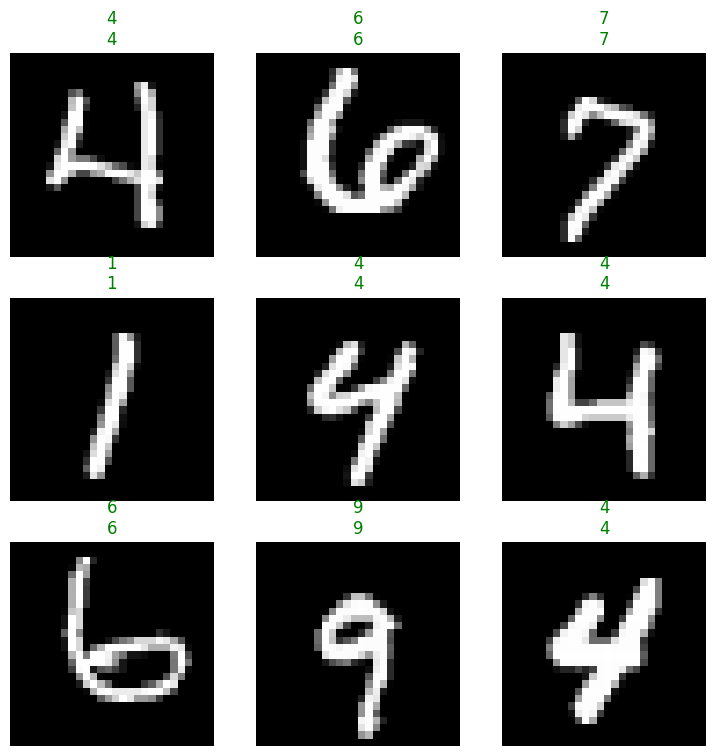

In [22]:
learn = Learner(DataLoaders([], sub_dsets.dl()), classifier, CrossEntropyLossFlat(), metrics=accuracy)
learn.show_results(shuffle=False)
benign_accuracy = learn.validate()[1]
test(benign_accuracy, .9, ge)

In [23]:
attack = PGD(classifier, CrossEntropyLossFlat(), targeted=False, epsilon=.15, n_epochs=10)
perturbed_dsets = attack.perturb(sub_dsets)

epoch,train_loss,time
0,-2.901809,00:00
1,-5.805852,00:00
2,-7.177372,00:00
3,-7.884405,00:00
4,-8.299075,00:00
5,-8.566442,00:00
6,-8.750227,00:00
7,-8.882083,00:00
8,-8.979425,00:00
9,-9.052908,00:00


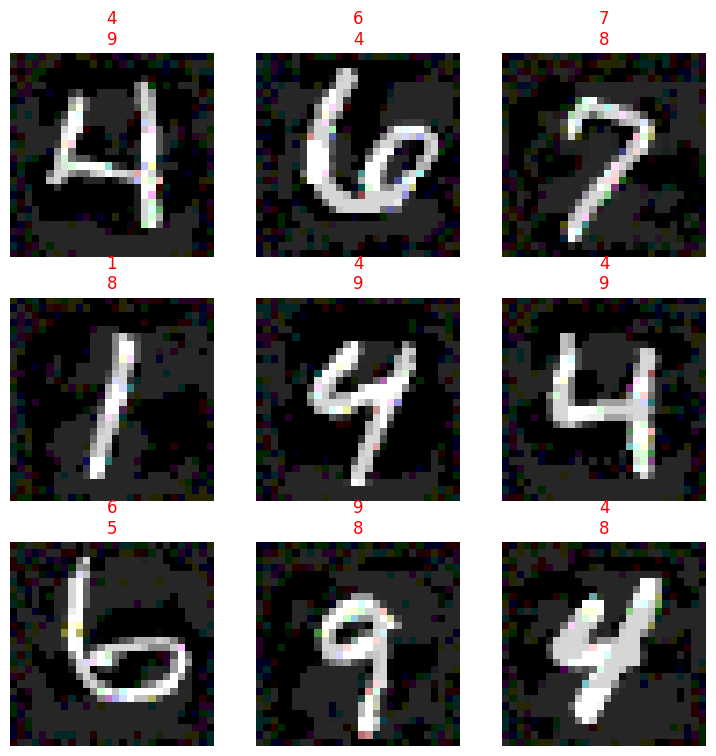

In [24]:
learn = Learner(DataLoaders([], TfmdDL(perturbed_dsets, shuffle=False)), classifier, CrossEntropyLossFlat(), metrics=accuracy)
learn.show_results(shuffle=False)
benign_accuracy = learn.validate()[1]
test(benign_accuracy, .1, le)

In [25]:
#| hide
import nbdev; nbdev.nbdev_export()